In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_

GPU is not available


In [2]:
model_tag='1.9.1.8.5_InternalSC_final_noQ_INP'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)

In [14]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/SpinalCord/manuscript/RNA/multispecies_integrated_aibs_SpC_aligned_labels.h5ad'),backed='r')
adata.uns['species_colors']=['blue','red','green','yellow','orange','cyan','magenta','teal','goldenrod','purple','maroon','pink','violet','black','grey','beige']
batch_key='batch'
discov_key='species'
layer_key='UMIs'

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer=layer_key,normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0])

100%|██████████| 14/14 [01:23<00:00,  5.98s/it]


In [15]:
adata

AnnData object with n_obs × n_vars = 883599 × 9327 backed at '/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination.h5ad'
    obs: 'species', 'dataset', 'path', 'gene.counts.0', 'umi.counts', 'exclude2', 'doublet_score', 'sex', 'organism', 'roi', 'ar_directory', 'ar_id', 'GEX_Reads_with_TSO', 'GEX_Reads_mapped_antisense_to_gene', 'GEX_Reads_mapped_confidently_to_exonic_regions', 'GEX_Reads_mapped_confidently_to_genome', 'GEX_Reads_mapped_confidently_to_intergenic_regions', 'GEX_Reads_mapped_confidently_to_intronic_regions', 'GEX_Reads_mapped_confidently_to_transcriptome', 'n_umis', 'n_genes', 'batch'
    uns: 'log1p', 'species_colors'
    layers: 'UMIs'

In [ ]:
adata.obsm['donor_name'] = numpy_onehot(adata.obs['donor_name'].astype('category').cat.codes)

In [23]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,25,200]
num_latent=100
steps=0
max_steps=600000
num_particles=3
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,bi_depth=2,num_batch_embed=10,psi_levels=[0.,1.,1.],seccov_key='donor_name',
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
                use_psi=False,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category=discov_key,dist_normalize=True,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=False)

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[UMIs] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [ ]:
antipode_model.run_standard_protocol(out_path,
                                     max_steps=max_steps,
                                     num_particles=num_particles,
                                     device=device,
                                     max_learning_rate=1e-3,
                                     one_cycle_lr=True,
                                     batch_size=batch_size)

In [13]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

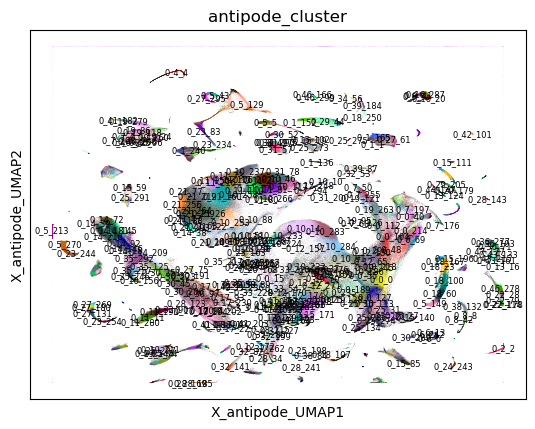

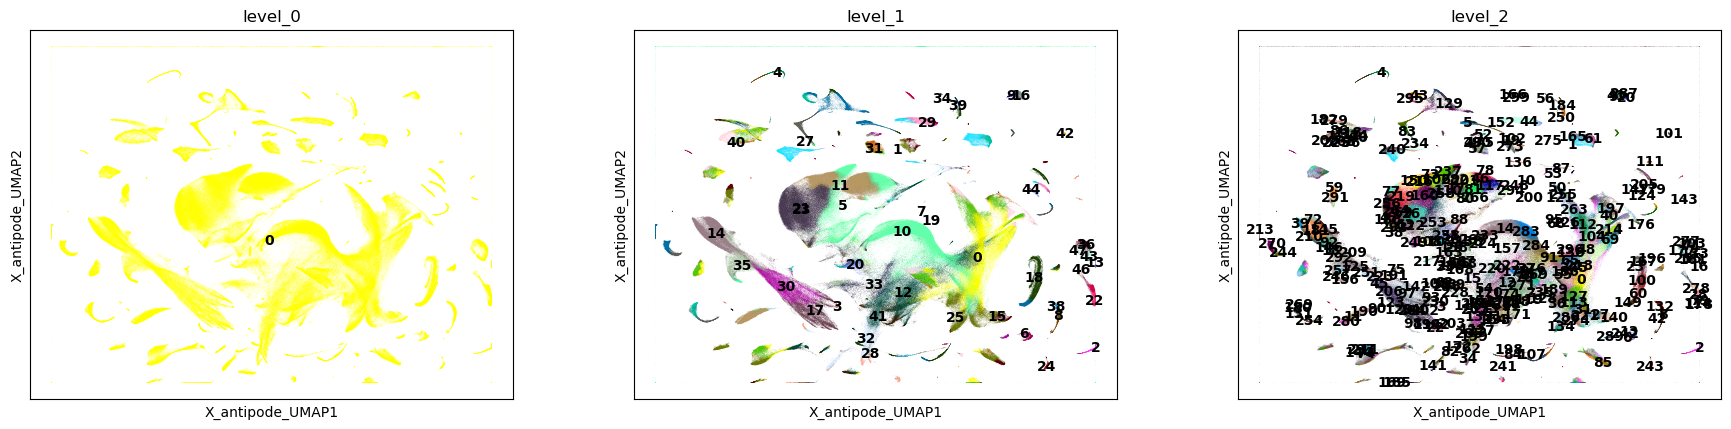

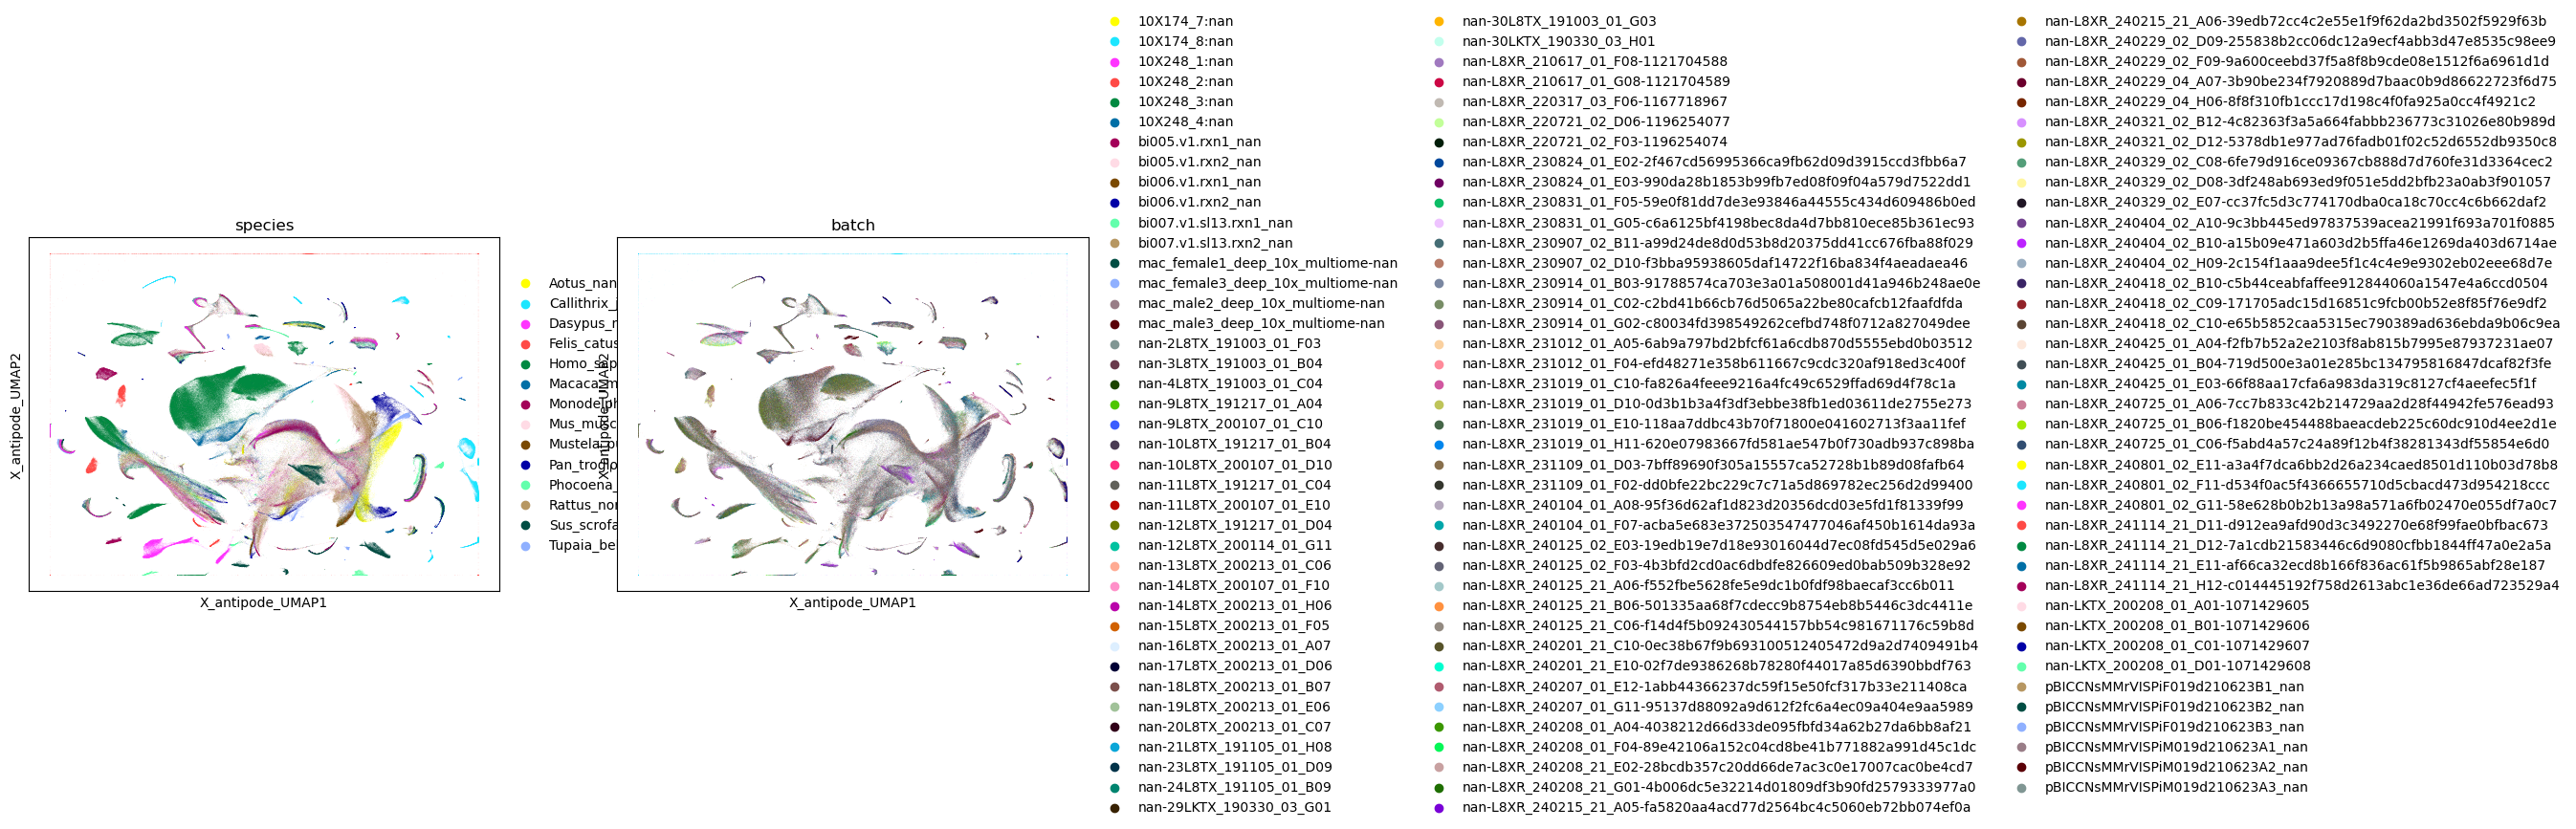

In [19]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key,batch_key]
)



In [ ]:
plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [ ]:
pstore=adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:]
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

In [ ]:
aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key,'level_2'],layer=layer_key,normalize=True)
log_real_means=antipode.model_functions.safe_log_transform(aggr_means[0]) # #species,#cluster,#genes array

In [ ]:
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=aggr_means[1]['level_2'])
real_means=real_means.loc[aggr_means[1]['level_2'],:]

In [ ]:
discov_cluster_params

In [ ]:
log_real_means.shape

In [ ]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


In [ ]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

In [ ]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

In [ ]:
print(cluster_index)
print(aggr_means[1]['level_2'])

In [ ]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
zeros=y>-20
x=x[zeros]
y=y[zeros]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

In [ ]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()